In [1]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
q='''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, ifnull(count(distinct sha),0) as commit_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join change_commit cc on ri.id = cc.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
cc = pd.DataFrame(sql.execute(q)) 

In [3]:
q= '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id,
       ifnull(count(distinct filename),0) as file_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where fe.source = 1) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
cf = pd.DataFrame(sql.execute(q))

In [4]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, 
       ifnull(sum(lines_added + lines_removed),0) as loc_change
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where fe.source = 1) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
loc = pd.DataFrame(sql.execute(q))

In [5]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id,
       ifnull(count(distinct author_mail),0) as contributor_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    join release_type rt on rt.release_info_id = ri.id
    left join change_commit cc on ri.id = cc.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    -- and rt.type = 'patch'
    group by advisory_id, p.ecosystem, a.package_id, ri.id'''
contrib = pd.DataFrame(sql.execute(q))

In [6]:
cc['release_id'].nunique() , cf['release_id'].nunique(), loc['release_id'].nunique(), contrib['release_id'].nunique()

(3381, 3381, 3381, 3381)

In [32]:
temp = cc.drop_duplicates(subset='release_id',keep='last')
temp['commit_count'].describe()

count      3381.000000
mean        175.213251
std        2647.988209
min           0.000000
25%           4.000000
50%          12.000000
75%          45.000000
max      100993.000000
Name: commit_count, dtype: float64

In [7]:
df = reduce(lambda x, y: pd.merge(x,y, on =['advisory_id','ecosystem', 'package_id', 'release_id']), [cc,cf,loc,contrib])
df['loc_change'] = df['loc_change'].apply(lambda x: 0 if x is None else x)
df['loc_change'] = df['loc_change'].astype(int)

In [8]:
total = ['Total', df['advisory_id'].nunique(), df['package_id'].nunique(), df['release_id'].nunique()]
temp = df.drop_duplicates(subset ='release_id', keep = 'last')
total += [temp['commit_count'].median(), temp['file_count'].median(), temp['loc_change'].median(), temp['contributor_count'].median()]
total

['Total', 3114, 1471, 3381, 12.0, 13.0, 402.0, 4.0]

In [9]:
q = ''' select ecosystem, count(distinct ri.id) as patch
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on
    fr.version = ri.version and ri.package_id = a.package_id
join release_commit rc on p.id = rc.package_id and rc.version = fr.version
join release_type rt on ri.id = rt.release_info_id
where rc.commit is not null and rt.type ='patch'
and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
-- and rt.type = 'patch'
group by ecosystem;'''


['Total', 3114, 1471, 3381, 12.0, 13.0, 402.0, 4.0, 2421]

In [ ]:
patch = pd.DataFrame(sql.execute(q))
total.append(patch['patch'].sum())
total

In [10]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')[['release_id']].nunique()
temp = df.drop_duplicates(subset ='release_id', keep = 'last')
commits =temp.groupby('ecosystem')[['commit_count']].median()
files = temp.groupby('ecosystem')[['file_count']].median()
loc_change = temp.groupby('ecosystem')[['loc_change']].median()
contributors = temp.groupby('ecosystem')[['contributor_count']].median()
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, commits, files, loc_change, contributors, patch])
final['temp'] = round(final['patch'] / final['release_id'] * 100 , 1)
final['patch'] = final['patch'].map(str) +' (' + final['temp'].map(str) +'%)'
total[-1] = str(total[-1]) + ' (' + str(round(total[-1] / total[3] * 100, 1)) +'%)'
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop('temp', axis=1)
final.loc[len(final)] = total
final

,ecosystem,advisory_id,package_id,release_id,commit_count,file_count,loc_change,contributor_count,patch
0,Composer,747,202,823,7.0,11.0,231.0,3.0,706 (85.8%)
1,Go,191,150,251,23.0,42.0,1640.0,8.0,191 (76.1%)
2,Maven,743,381,897,37.0,49.0,2064.0,6.0,514 (57.3%)
5,npm,573,379,605,6.0,5.0,155.0,2.0,410 (67.8%)
3,NuGet,229,56,141,11.0,14.0,498.0,7.0,128 (90.8%)
6,pip,442,202,402,16.0,11.0,244.5,4.0,276 (68.7%)
4,RubyGems,189,101,262,5.0,10.0,88.5,2.0,196 (74.8%)
7,Total,3114,1471,3381,12.0,13.0,402.0,4.0,2421 (71.6%)


In [11]:
temp = df.drop_duplicates(subset ='release_id', keep = 'last')
len(temp)
temp['loc_change'].describe()

count    3.381000e+03
mean     6.647873e+04
std      1.225089e+06
min      0.000000e+00
25%      7.500000e+01
50%      4.020000e+02
75%      2.916000e+03
max      5.395807e+07
Name: loc_change, dtype: float64

In [12]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrrrl}
\hline
 ecosystem   &   advisory\_id &   package\_id &   release\_id &   commit\_count &   file\_count &   loc\_change &   contributor\_count & patch        \\
\hline
 Composer    &           747 &          202 &          823 &              7 &           11 &        231   &                   3 & 706 (85.8\%)  \\
 Go          &           191 &          150 &          251 &             23 &           42 &       1640   &                   8 & 191 (76.1\%)  \\
 Maven       &           743 &          381 &          897 &             37 &           49 &       2064   &                   6 & 514 (57.3\%)  \\
 npm         &           573 &          379 &          605 &              6 &            5 &        155   &                   2 & 410 (67.8\%)  \\
 NuGet       &           229 &           56 &          141 &             11 &           14 &        498   &                   7 & 128 (90.8\%)  \\
 pip         &           442 &          202 &          402 &           

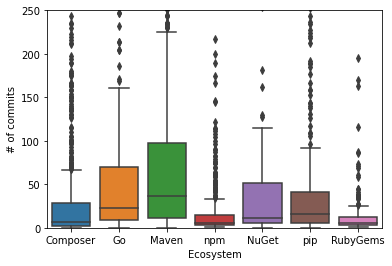

In [13]:
ax = sns.boxplot(y='commit_count', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems'])
ax.set(ylim=(0,250), xlabel='Ecosystem', ylabel='# of commits')
plt.savefig('commit_complexity.png',bbox_inches='tight')

In [14]:
q = '''select id as advisory_id, severity
    from advisory'''
sev = pd.DataFrame(sql.execute(q))
sev

,advisory_id,severity
0,npm:abaaso:20180220,L
1,npm:actionhero:20121127,M
2,npm:actionhero:20161027,M
3,npm:address-rfc2822:20180225,H
4,npm:adm-zip:20180415,H
...,...,...
6951,SNYK-RUBY-WRITTEN-548685,M
6952,SNYK-RUBY-YARD-20430,L
6953,SNYK-RUBY-YARD-455636,H
6954,SNYK-RUBY-ZIPRUBY-20431,H


In [15]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, 
       ifnull(sum(lines_added + lines_removed),0) as loc_change
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where filename in ({})) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    and ri.prior_release != 'branch does not match'
            and ri.prior_release != 'not valid semver formatting'
    and p.ecosystem = %s
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
hm = {
    'npm': ['package.json','package-lock.json','yarn.lock'],
    'Maven':['pom.xml'],
    'RubyGems': ['Gemfile','Gemfile.lock'],
    'Composer':['composer.json','composer.lock'],
    'Go':['go.mod','Gopkg.toml','Gopkg.lock','vendor/vendor.json'],
    'pip':['requirements.txt','pipfile','pipfile.lock','setup.py'],
    'NuGet':['packages.config','.nuspec']
}
for k in hm.keys():
    query = q.format(','.join(['%s']*len(hm[k])))
    dep_cf = pd.DataFrame(sql.execute(query, tuple(hm[k]+[k])))
    dep_cf = dep_cf.drop_duplicates(subset='release_id', keep='last')
    print(k, dep_cf['loc_change'].median())


npm 4.0
Maven 4.0
RubyGems 0.0
Composer 0.0
Go 0.0
pip 0.0
NuGet 0.0


In [16]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))
df = pd.merge(df, ifcve, on='advisory_id')

In [17]:
from scipy.stats import mannwhitneyu

In [18]:
cve = df[df['ifcve'] == 'cve']
cve = cve.drop_duplicates(subset='release_id', keep='last')
noncve = df[df['ifcve'] == 'noncve']
noncve = noncve.drop_duplicates(subset='release_id', keep='last')
cve['commit_count'].median(), noncve['commit_count'].median(), cve['loc_change'].median(), noncve['loc_change'].median()

(14.0, 9.0, 436.0, 313.0)

In [19]:

mannwhitneyu(cve['commit_count'], noncve['commit_count']), mannwhitneyu(cve['loc_change'], noncve['loc_change'])

(MannwhitneyuResult(statistic=981361.0, pvalue=0.0010540344494287014),
 MannwhitneyuResult(statistic=986343.5, pvalue=0.0020593479045196436))

In [20]:
q='''select id as advisory_id, severity
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))
df = pd.merge(df, ifcve, on='advisory_id')
df

,advisory_id,ecosystem,package_id,release_id,commit_count,file_count,loc_change,contributor_count,ifcve,severity
0,npm:actionhero:20161027,npm,3419,42,9,7,59,2,noncve,M
1,npm:adm-zip:20180415,npm,2289,45,3,5,83,1,cve,H
2,npm:aerospike:20161101,npm,2956,48,8,9,235,1,cve,H
3,npm:ag-grid:20160519,npm,3410,49,46,270,10450,2,noncve,M
4,npm:angular-gettext:20140624,npm,3384,64,1,0,0,1,noncve,M
...,...,...,...,...,...,...,...,...,...,...
4734,SNYK-RUBY-WEBRICK-1013845,RubyGems,438,5474,2,2,8,2,cve,H
4735,SNYK-RUBY-WEBRICK-1013845,RubyGems,438,5475,2,2,8,2,cve,H
4736,SNYK-RUBY-WEBSOCKETEXTENSIONS-570830,RubyGems,843,5492,6,4,64,1,cve,H
4737,SNYK-RUBY-YARD-20430,RubyGems,1699,5548,5,5,126,3,noncve,L


In [21]:
l, m, h = df[df['severity']=='L'],df[df['severity']=='M'],df[df['severity']=='H']
l,m,h = l.drop_duplicates(subset='release_id', keep='last'), m.drop_duplicates(subset='release_id', keep='last'), h.drop_duplicates(subset='release_id', keep='last')
l['commit_count'].median(), m['commit_count'].median(), h['commit_count'].median()

(23.0, 15.0, 11.0)

In [22]:
mannwhitneyu(l['commit_count'], m['commit_count']), mannwhitneyu(m['commit_count'],h['commit_count']), mannwhitneyu(l['commit_count'], h['commit_count'])

(MannwhitneyuResult(statistic=166430.5, pvalue=0.0006684683400602531),
 MannwhitneyuResult(statistic=1377511.5, pvalue=6.660103874449753e-05),
 MannwhitneyuResult(statistic=128182.5, pvalue=1.5205796637870068e-07))

In [23]:
l['loc_change'].median(), m['loc_change'].median(), h['loc_change'].median()

(851.0, 453.5, 418.0)

In [24]:
mannwhitneyu(['loc_change'],m['loc_change']), mannwhitneyu(m['loc_change'], h['loc_change']), mannwhitneyu(l['loc_change'], h['loc_change'])

(MannwhitneyuResult(statistic=0.0, pvalue=0.0417940107714064),
 MannwhitneyuResult(statistic=1437503.5, pvalue=0.038227491151269534),
 MannwhitneyuResult(statistic=139363.5, pvalue=0.00021356824876309516))

In [25]:
len(noncve)

811

In [26]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,release_id,
        earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
       concat(advisory_id, package_id, version) as total_release
        from
        (select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date, ri.id as release_id
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
frd = pd.DataFrame(sql.execute(q))
def get_fix_commit_date(row):
    if row['earliest_fix_commit_date'] == row['latest_fix_commit_date']:
        return row['earliest_fix_commit_date']
    else:
        if row['latest_fix_commit_date'] <= row['release_date']:
            return row['latest_fix_commit_date']
        else:
            return row['earliest_fix_commit_date']

frd['fix_commit_date'] = frd.apply(get_fix_commit_date, axis=1)
frd['fix_to_release_delay'] = (frd['release_date'] - frd['fix_commit_date']).dt.total_seconds()
frd['fix_to_release_delay'] = round ( frd['fix_to_release_delay'] / (3600 * 24))
frd['disclose_to_fix_delay'] = (frd['fix_commit_date'].dt.date - frd['disclose_date']).dt.days
frd['release_to_publish_delay'] = (frd['publish_date'] - frd['release_date'].dt.date).dt.days
frd['fix_to_publish_delay'] = (frd['publish_date'] - frd['fix_commit_date'].dt.date).dt.days

In [27]:
frd = frd[['advisory_id','release_id','fix_to_release_delay']]
temp = pd.merge(df, frd, on=['advisory_id', 'release_id'])

In [28]:
len(df), len(frd), len(temp)

(4739, 2789, 2375)

In [29]:
temp = temp[temp['fix_to_release_delay']==0]
temp = temp.drop_duplicates(subset='release_id', keep='last')

In [30]:
temp['commit_count'].median(), temp['loc_change'].median(), temp['file_count'].median(), temp['contributor_count'].median()

(6.0, 149.0, 7.0, 2.0)

In [31]:
temp = temp.sample(frac=1).reset_index(drop=True)
temp.to_csv('secrel_with_zero_delay.csv', index=False, header=True)